In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
PATH = 'C:/Users/SAKIB/Downloads/BC_cells_datasetForSegmentation/train'
os.listdir(PATH)

['train_image', 'train_mask']

In [3]:
images=glob.glob(os.path.join(PATH,'train_image','*.tif'))
mask=glob.glob(os.path.join(PATH,'train_mask','*.TIF'))
len(images), len(mask)

(30, 30)

In [4]:
def get_data(path, resize_dim=128):
    img=cv2.imread(path,0)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img_rz

In [5]:
def get_data_gif(path, resize_dim=128):
    img=plt.imread(path)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img_rz

In [6]:
orig_images=np.array([get_data(path) for path in images])
orig_images.shape

(30, 128, 128)

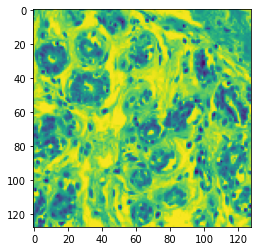

In [7]:
plt.imshow(orig_images[0])

In [8]:
masks=np.array([get_data_gif(path) for path in mask])
masks.shape

(30, 128, 128)

In [9]:
orig_images = np.expand_dims(orig_images, axis = -1)
masks = np.expand_dims(masks, axis = -1)

In [10]:
masks.shape, orig_images.shape

((30, 128, 128, 1), (30, 128, 128, 1))

In [11]:
orig_images = orig_images / 255
masks = masks / 255

In [12]:
def get_unet():
    inputs = Input((128, 128, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adagrad(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [13]:
model = get_unet()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [14]:
model.fit(orig_images, masks, epochs = 10, batch_size= 2, shuffle = True, validation_split = 0.1)

Train on 27 samples, validate on 3 samples
Epoch 1/10
27/27 [==============================] - 19s 695ms/step - loss: 0.6644 - accuracy: 0.9692 - val_loss: 0.6438 - val_accuracy: 0.9770
Epoch 2/10
27/27 [==============================] - 18s 673ms/step - loss: 0.3718 - accuracy: 0.9720 - val_loss: 0.1256 - val_accuracy: 0.9770
Epoch 3/10
27/27 [==============================] - 18s 675ms/step - loss: 0.1399 - accuracy: 0.9720 - val_loss: 0.1213 - val_accuracy: 0.9770
Epoch 4/10
27/27 [==============================] - 18s 672ms/step - loss: 0.1335 - accuracy: 0.9720 - val_loss: 0.1137 - val_accuracy: 0.9770
Epoch 5/10
27/27 [==============================] - 18s 671ms/step - loss: 0.1293 - accuracy: 0.9720 - val_loss: 0.1092 - val_accuracy: 0.9770
Epoch 6/10
27/27 [==============================] - 18s 670ms/step - loss: 0.1250 - accuracy: 0.9720 - val_loss: 0.1076 - val_accuracy: 0.9770
Epoch 7/10
27/27 [==============================] - 18s 674ms/step - loss: 0.1212 - accuracy: 0.972

In [15]:
PATH1 = 'C:/Users/SAKIB/Downloads/BC_cells_datasetForSegmentation'

In [16]:
t_images=glob.glob(os.path.join(PATH1,'test','*.tif'))

In [17]:
test_images=np.array([get_data(path) for path in t_images])
test_images.shape

(28, 128, 128)

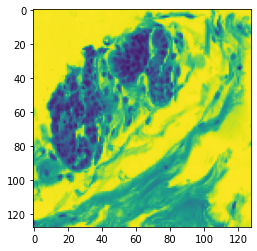

In [18]:
plt.imshow(test_images[0])

In [19]:
test_images = np.expand_dims(test_images, axis = -1)

In [20]:
test_images.shape

(28, 128, 128, 1)

In [21]:
test_images = test_images / 255

In [22]:
imgs_mask_test = model.predict(test_images, verbose=1)

28/28 [==============================] - 3s 99ms/step


In [23]:
idx = random.randint(0, len(imgs_mask_test))
i = imgs_mask_test[idx]
i = i[:, :, 0]
i.shape

(128, 128)

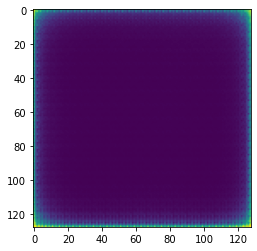

In [24]:
plt.imshow(i)

In [25]:
yp = np.round(imgs_mask_test,0)

In [26]:
idx = random.randint(0, len(yp))
i = imgs_mask_test[idx]
i = i[:, :, 0]
i.shape

(128, 128)

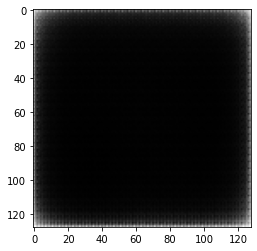

In [27]:
plt.imshow(i, cmap='gray')